# Home Credit Default Risk Using BigML

### Description
While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data.


### Import Modules
<ul>
<li>You will first need to install a number of modules in order to follow along with this notebook. 
<li>Most of these packages, such as numpy and pandas, are available using <a href="https://conda.io/docs/user-guide/install/index.html">Anaconda</a>. 
<li>For the machine learning pipeline, we will be making use of the <a href="https://bigml.readthedocs.io/en/latest/">BigML Python bindings</a>.
</ul>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

In [9]:
import sys
print(sys.version)

3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


### Save our BigML Username and Api Key to our environment to access the API

In [2]:
import os
os.environ['BIGML_USERNAME'] = "efetoros"
os.environ['BIGML_API_KEY'] = "7e5fc6a649fd0f8517fc8ecf2ebd30151c5d4fb4"

### Creating our main API object with the input of our project id. The project will enable us tp organize and keep track of our resources created.

In [3]:
from bigml.api import BigML
API = BigML(project="project/5b17bf902a83471197002331")

### Downloading Data
For this competition, the data is provided in several distinct csv files. These relationships between the files are visualized in the chart below, which enables us to see the common IDs we will need to know for merging.

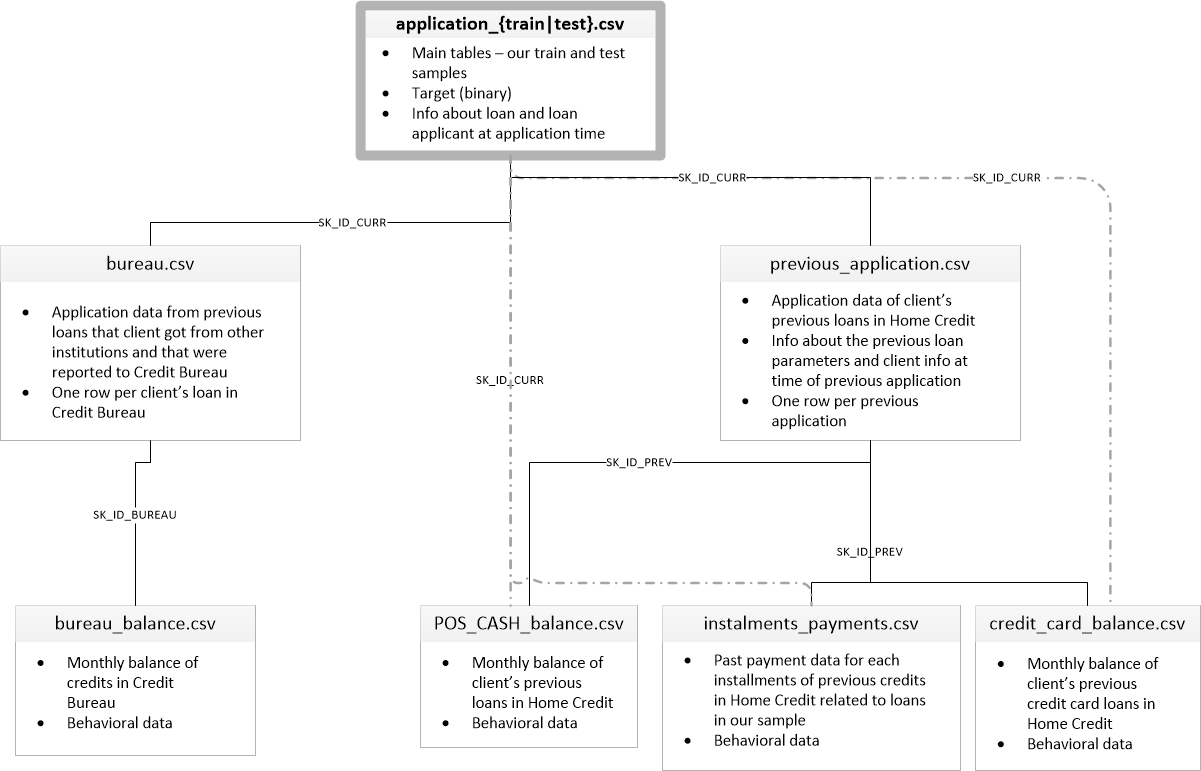

We use <code>read_csv</code> to download each table provided into a pandas DataFrame. 

In [4]:
application_train = pd.read_csv("data/application_train.csv")
application_test = pd.read_csv("data/application_test.csv")
bureau = pd.read_csv("data/bureau.csv")
bureau_balance = pd.read_csv("data/bureau_balance.csv")
credit_card_balance = pd.read_csv("data/credit_card_balance.csv")
installments_payments = pd.read_csv("data/installments_payments.csv")
previous_application = pd.read_csv("data/previous_application.csv")
POS_CASH_balance = pd.read_csv("data/POS_CASH_balance.csv")

### Data Cleaning
In Pandas, the <code>get_dummies</code> method will create dummy variables from categorical variables.
<br/> All transformations must also be applied to the test set.


In [5]:
application_test_dummies = pd.get_dummies(application_test)
application_train_dummies = pd.get_dummies(application_train)

full_bureau = bureau.merge(bureau_balance, on= "SK_ID_BUREAU")
full_bureau_dummies = pd.get_dummies(full_bureau)

previous_application_dummies = pd.get_dummies(previous_application)
credit_card_balance_dummies = pd.get_dummies(credit_card_balance)
installments_payments_dummies = pd.get_dummies(installments_payments)
POS_CASH_balance_dummies = pd.get_dummies(POS_CASH_balance)

The <code>groupby</code> method will take in a label to create certain groups and a function to aggregate. Below, the dataframes are grouped on the label SK_ID_CURR and use the aggregate method <code>mean</code>.

In [6]:
application_test_avg = application_test_dummies.groupby("SK_ID_CURR").mean()
app_train_avg = application_train_dummies.groupby("SK_ID_CURR").mean()
full_bureau_avg = full_bureau_dummies.groupby("SK_ID_CURR").mean()
previous_application_avg=previous_application_dummies.groupby("SK_ID_CURR").mean()
credit_card_balance_avg = credit_card_balance_dummies.groupby("SK_ID_CURR").mean()
installments_payments_avg = installments_payments_dummies.groupby("SK_ID_CURR").mean()
POS_CASH_balance_avg = POS_CASH_balance_dummies.groupby("SK_ID_CURR").mean()


The <code>reduce</code> method will enable the clean merging of all dataframes. By analyzing the chart before, one can see that the application train dataframe must be placed in the start of the list that is being left merged, otherwise new applicants would be dropped in the merging process. 


In [7]:
from functools import reduce

In [10]:
# Merge all tables that will be used for training on their indices created by the Groupby
dfs = [app_train_avg,previous_application_avg,full_bureau_avg, credit_card_balance_avg, installments_payments_avg, POS_CASH_balance]
df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how="left"), dfs)

In [11]:
# Merge all tables that will be used for our final batch prediction on their indices created by the Groupby
dfs = [application_test_avg,previous_application_avg,full_bureau_avg, credit_card_balance_avg, installments_payments_avg, POS_CASH_balance]
df_test_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how="left"), dfs)


Panda's methos <code>to_csv</code> will convert a dataframe to a csv file. 

In [12]:
df_final.to_csv("data/Avg_info_deafult_loans.csv")
df_test_final.to_csv("data/Modified_Test_Set.csv")

### Importing Data to BigML
In order to start a BigML workflow, a source object has to be created. The API function that creates a source is <code>create_source</code>. The method's inputs will be a file path to the csv it will be converting. The source will be created from the csv files written by <code>to_csv</code> from before. More documentation on <code>create_source</code> can be found at <a href="https://bigml.com/api/sources#sr_creating_a_source">BigML API Source Doc.</a>.

In [13]:
source = API.create_source("data/Avg_info_deafult_loans.csv")
test_source = API.create_source("data/Modified_Test_Set.csv")

<br /> BigML will use the newly created sources to create datasets which will enable the API to perform many more operations. In order to create a dataset, the API calls the function <code>create_dataset</code>. The method will take the sources created by the API as inputs. More details on <code>create_dataset</code> can be found at <a href="https://bigml.com/api/datasets#ds_creating_a_dataset">BigML API Dataset Doc.</a>.

In [14]:
full_dataset = API.create_dataset(source)
full_test_dataset = API.create_dataset(test_source)

BigML's <code>ok</code> method is called in order to assure that an object is created and will wait if it is not done being completed.

In [15]:
API.ok(full_dataset)
API.ok(full_test_dataset)

True

### Test-Train Split
Since we want our data to stay in the form of BigML's datasets, the test-train split of the data will be done through BigML's API. This form will allow for the API's computations. The test-train split will be created by the function <code>create_dataset</code> mentioned before. However, it will take advantage of the more available inputs of the function. Many BigML API functions take in a dictionary with many fields as an additional input. These fields allow for much manipulation of the original function's outcome. In a test-train split, the field of sample_rate will allow for the choosing of the percentage of data being sampled. The train dataset will have out_of_bag field set to False and the test dataset will have it set to True. Since the test out_of_bag is set to True, its size will be 20% when its sample rate is 80%. More information on these fields can be found at <a href="https://bigml.com/api/datasets#ds_dataset_properties">BigML Create Dataset Fields.</a>.

In [16]:
train_dataset = API.create_dataset(
    full_dataset, {"name": "Dataset Name | Training",
                     "sample_rate": 0.8, "seed": "my seed"})
train_test_dataset = API.create_dataset(
    full_dataset, {"name": "Dataset Name | Test",
                     "sample_rate": 0.8, "seed": "my seed",
                     "out_of_bag": True})

API.ok(train_dataset)
API.ok(train_test_dataset)

True

### Building our first model
BigML's API allows for the creation of many models. For this dataset, logistic regression will be used. The BigML API will use the method <code>create_logistic_regression</code>. As stated before, the method takes an additional input of a dictionary. This input allows for the setting of the Objective field, which will be TARGET in this model. More information about <code>create_logistic_regression</code> can be found at <a href="https://bigml.com/api/logisticregressions#lr_creating_a_logistic_regression">BigML Create Logistic Regression.</a>.

In [17]:
logistic_regression = API.create_logistic_regression(train_dataset, {"name": "credit_default_logistic regression",
                                                        "objective_field": "TARGET"})
API.ok(logistic_regression)

True

### Evaluating our model performance
BigML's API method <code>create_evaluation</code> will create an evaluation on BigML models. To conduct an evaluation on the logistic regression model created for this dataset, we will use the model object along with the test dataset as inputs. To extract information from the evaluation, one could use the BigML UI or extract fields from the output evaluation object. More information about creating evaluations can be found at <a href="https://bigml.com/api/evaluations#ev_creating_an_evaluationn">BigML Create Logistic Regression.</a>.


In [18]:
evaluation = API.create_evaluation(logistic_regression, train_test_dataset)
API.ok(evaluation)

True

----------------------------------------------------------------------------------------------------------------------

### Using the BigML Dashboard to dig deeper
As seen in the BigMl Interface below, at first glance it appears if our model did amazing since the accuracy is 91.9%. However, looking into the confusion matrix, we can see that the false cases had a very low recall percentage, implying that our accuracy is only high because there is an unbalance between the positive and negative cases.

----------------------------------------------------------------------------------------------------------------------

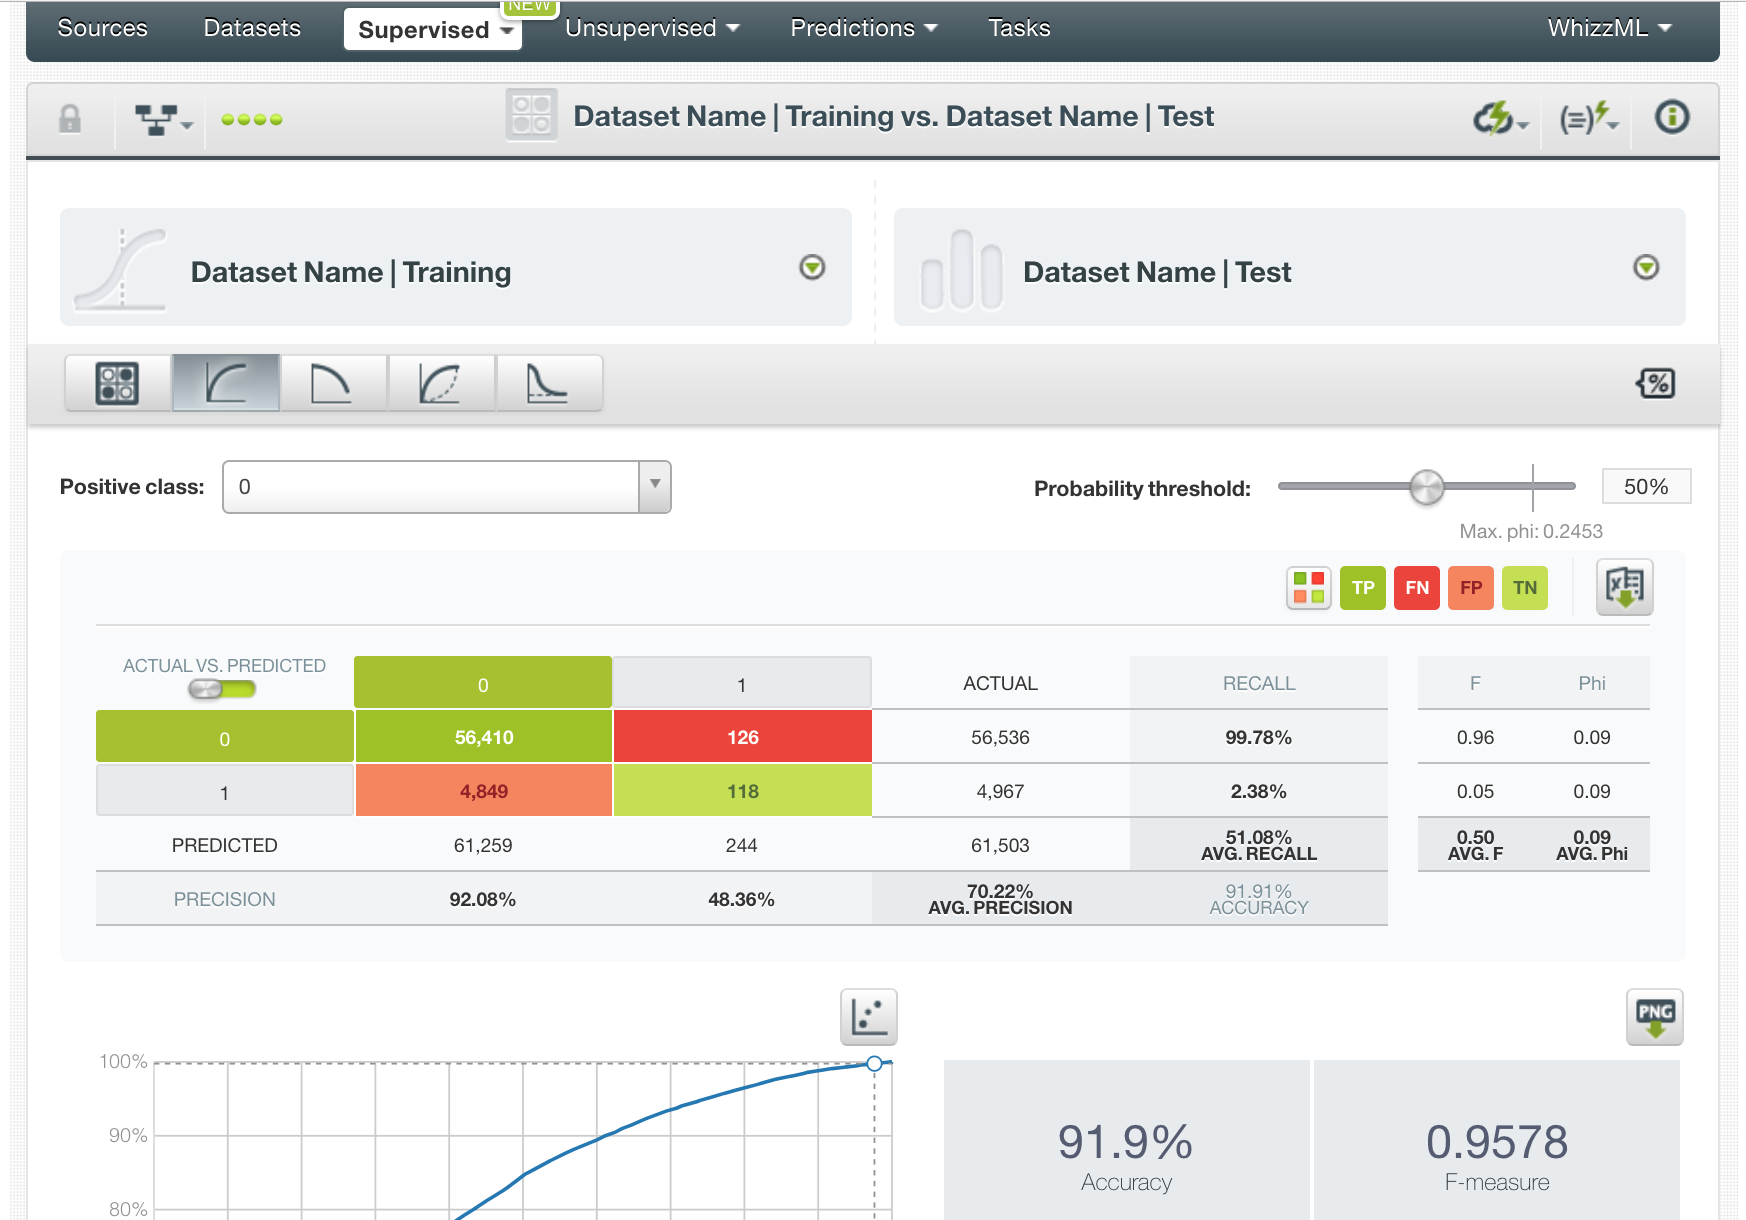

----------------------------------------------------------------------------------------------------------------------

### Operating Thresholds
In order to account for this unbalance, we will have to find a probability threshold that will create a more appropriate model. This threshold can be often times set to the Max. phi coefficient.

----------------------------------------------------------------------------------------------------------------------

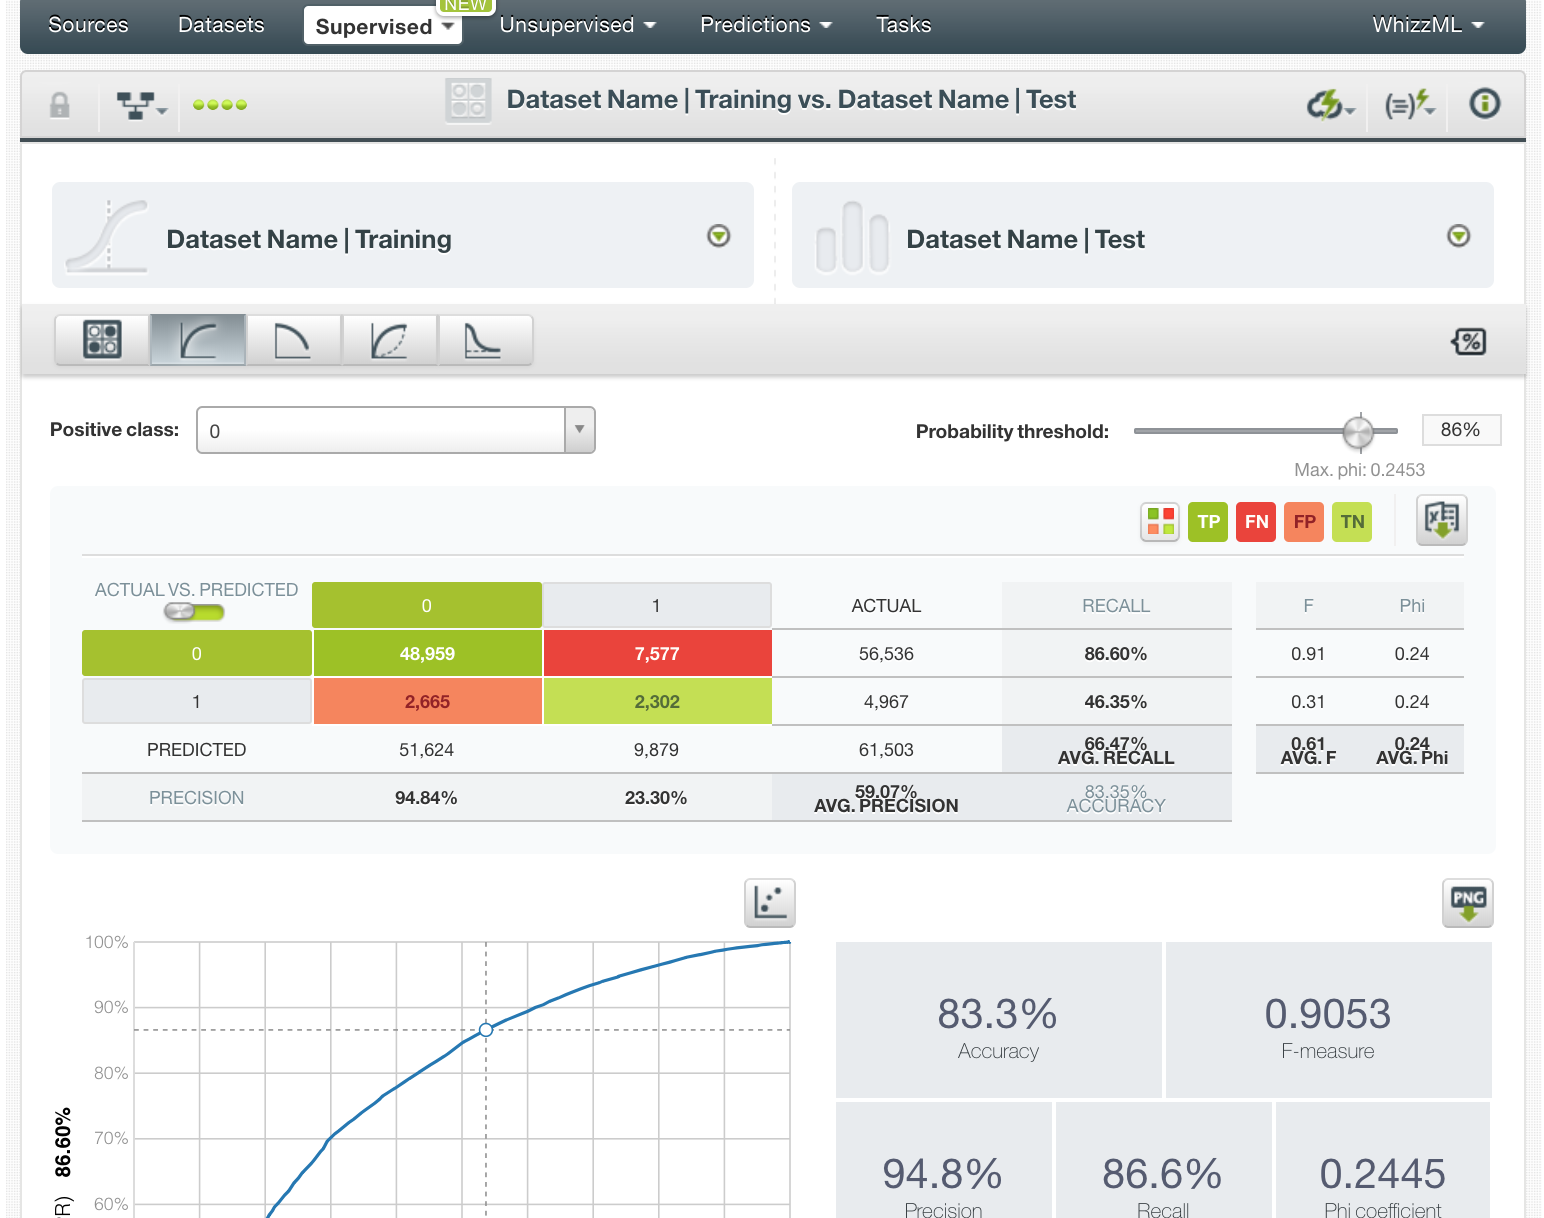

### Creating a Batch Prediction
The last step of this this workflow will be creating the final batch prediction. This can be done by using BigML's API method <code>create_batch_prediction</code>. The method's main inputs will be the model being used and the dataset that the prediction will be based off of. Additional inputs will be in the fields of the dictionary input. For the batch prediction of this dataset, we will set the header, confidence and all_fields to True. More importantly, we will add operating_point, and this is where we will input our probability threshold that was learned from the analysis of the UI. More information about <code>create_batch_prediction</code> can be found at <a href="https://bigml.com/api/batchpredictions#bp_creating_a_batch_prediction">BigML Create Batch Prediction.</a>.

In [19]:
#Create final batch prediction with the arguments that you prefer, a full list of arguments to choose form 
#can be found on BigMl's Api manual
batch_prediction = API.create_batch_prediction(logistic_regression, full_test_dataset, {
    "name": "my batch prediction", "all_fields": True,
    "header": True,
    "confidence": True,
"operating_point": {
    "kind": "probability",
    "positive_class": "0",
    "threshold": 0.83
}})
API.ok(batch_prediction)

True

### Download Batch Prediction
BigML's API function <code>download_batch_prediction</code> will allow for the download of the batch prediction. The inputs to the method will be the output filename and the batch prediction created. The default download will be comma separated (CSV).

In [20]:
API.download_batch_prediction(batch_prediction,
    filename='my_prediction.csv')

'my_prediction.csv'

# Closing Notes
### This small workflow comes out with a .703 prediction. More improvement can be made by further feature engineering and finding the optimal probability threshold.
### All BigML operations are drawn from the BigML API, and full documentation can be found at <a href="https://bigml.com/api">BigML API Documentation</a>. This notebook used the API's python bindings, and full documentation can be found at <a href="https://bigml.readthedocs.io/en/latest/#">BigML API Python Bindings</a>.
